In [3]:
import boto3

import pandas as pd 
import numpy as np
import holidays

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/Pog-Series/Rob-Sleep-Prediction/train.csv'
file_key_2 = 'Tabular-Playground-Series/Pog-Series/Rob-Sleep-Prediction/test.csv'
file_key_3 = 'Tabular-Playground-Series/Pog-Series/Rob-Sleep-Prediction/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
train['date'] = pd.to_datetime(train['date'])

test = pd.read_csv(file_content_stream_2)
test['date'] = pd.to_datetime(test['date'])

submission = pd.read_csv(file_content_stream_3)

def get_holidays(df):
    years_list = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

    holiday_US = holidays.CountryHoliday('US', years = years_list)
    holiday_dict = holiday_US.copy()

    df['holiday_name'] = df['date'].map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')
    
    return df.drop(columns = ['holiday_name'])


def feature_engineer(df):
    
    new_df = df.copy()
    new_df["month"] = df["date"].dt.month
    new_df["month_sin"] = np.sin(new_df['month'] * (2 * np.pi / 12))
#     new_df["month_cos"] = np.cos(new_df['month'] * (2 * np.pi / 12))
    
    new_df["day"] = df["date"].dt.day
    new_df["day_sin"] = np.sin(new_df['day'] * (2 * np.pi / 12))
#     new_df["day_cos"] = np.cos(new_df['day'] * (2 * np.pi / 12))
    
    new_df["day_of_week"] = df["date"].dt.dayofweek
#     new_df["day_of_week"] = new_df["day_of_week"].apply(lambda x: 0 if x <= 3 else(1 if x == 4 else (2 if x == 5 else (3))))
    
    new_df["day_of_year"] = df["date"].dt.dayofyear
    new_df["year"] = df["date"].dt.year
    
    return new_df

train = feature_engineer(train)
test = feature_engineer(test)

train = get_holidays(train)
test = get_holidays(test)

train.loc[((train['date'] >= '2017-09-27') & (train['date'] <= '2018-06-12')), 'sleep_hours'] = train.loc[((train['date'] >= '2017-09-27') & (train['date'] <= '2018-06-12')), 'sleep_hours'] / 1.94 

X = train.drop(columns = ['date', 'sleep_hours', 'year'], axis = 1)
Y = train['sleep_hours']

test = test.drop(columns = ['date', 'sleep_hours', 'year'], axis = 1)

train = train[train['date'] > '2015-07-20'].reset_index(drop = True)

In [4]:
train.head()

,date,sleep_hours,month,month_sin,day,day_sin,day_of_week,day_of_year,year,is_holiday
0,2015-07-21,7.850000,7,-0.5,21,-1.000000e+00,1,202,2015,0
1,2015-07-22,5.916667,7,-0.5,22,-8.660254e-01,2,203,2015,0
2,2015-07-23,6.916667,7,-0.5,23,-5.000000e-01,3,204,2015,0
3,2015-07-24,6.450000,7,-0.5,24,-4.898587e-16,4,205,2015,0
4,2015-07-25,7.783333,7,-0.5,25,5.000000e-01,5,206,2015,0


In [5]:
train_agg = pd.DataFrame(train.groupby(['month', 'day_of_week'])['sleep_hours'].mean()).reset_index()
train_agg.head(20)

,month,day_of_week,sleep_hours
0,1,0,6.607022
1,1,1,6.437583
2,1,2,6.247111
3,1,3,6.830944
4,1,4,6.757709
5,1,5,6.895420
6,1,6,7.021891
7,2,0,6.405351
8,2,1,6.412428
9,2,2,6.697199


(array([ 1.,  0.,  1.,  8., 18., 19., 12., 14.,  8.,  3.]),
 array([5.89174227, 6.02274989, 6.1537575 , 6.28476512, 6.41577274,
        6.54678036, 6.67778797, 6.80879559, 6.93980321, 7.07081082,
        7.20181844]),
 <BarContainer object of 10 artists>)

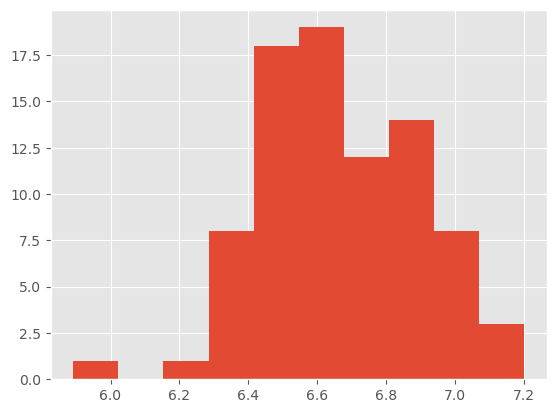

In [6]:
plt.hist('sleep_hours', data = train_agg)

In [7]:
test.head()

,month,month_sin,day,day_sin,day_of_week,day_of_year,is_holiday
0,1,0.5,1,0.500000,5,1,1
1,1,0.5,2,0.866025,6,2,0
2,1,0.5,3,1.000000,0,3,0
3,1,0.5,4,0.866025,1,4,0
4,1,0.5,5,0.500000,2,5,0


In [8]:
test_new = pd.merge(test[['month', 'day_of_week']], train_agg, on = ['month', 'day_of_week'], how = 'left')
test_new.head(10)

,month,day_of_week,sleep_hours
0,1,5,6.895420
1,1,6,7.021891
2,1,0,6.607022
3,1,1,6.437583
4,1,2,6.247111
5,1,3,6.830944
6,1,4,6.757709
7,1,5,6.895420
8,1,2,6.247111
9,1,3,6.830944


In [22]:
ridge_pred = pd.read_csv('ridge_baseline_optuna_submission.csv')
lasso_pred = pd.read_csv('lasso_baseline_optuna_submission.csv')
elastic_pred = pd.read_csv('elastic_baseline_optuna_submission.csv')
hist_pred = pd.read_csv('hist_baseline_optuna_submission.csv')
lgb_pred = pd.read_csv('lgb_baseline_optuna_submission.csv')

print(ridge_pred.head(10))
print(lasso_pred.head(10))
print(elastic_pred.head(10))
print(hist_pred.head(10))
print(lgb_pred.head(10))

         date  sleep_hours
0  2022-01-01     6.948269
1  2022-01-02     6.952025
2  2022-01-03     6.503058
3  2022-01-04     6.578379
4  2022-01-05     6.655324
5  2022-01-06     6.733208
6  2022-01-07     6.811091
7  2022-01-08     6.888036
8  2022-01-19     6.658859
9  2022-01-20     6.735804
         date  sleep_hours
0  2022-01-01     6.864333
1  2022-01-02     6.932096
2  2022-01-03     6.523519
3  2022-01-04     6.591282
4  2022-01-05     6.659045
5  2022-01-06     6.726808
6  2022-01-07     6.794571
7  2022-01-08     6.862334
8  2022-01-19     6.655048
9  2022-01-20     6.722811
         date  sleep_hours
0  2022-01-01     6.866215
1  2022-01-02     6.934900
2  2022-01-03     6.520815
3  2022-01-04     6.589500
4  2022-01-05     6.658185
5  2022-01-06     6.726870
6  2022-01-07     6.795554
7  2022-01-08     6.864239
8  2022-01-19     6.654233
9  2022-01-20     6.722918
         date  sleep_hours
0  2022-01-01     7.028662
1  2022-01-02     6.762038
2  2022-01-03     6.578467
3

In [13]:
submission['pred1'] = test_new['sleep_hours']
submission['pred2'] = ridge_pred['sleep_hours']
submission['pred3'] = lasso_pred['sleep_hours']
submission['pred4'] = elastic_pred['sleep_hours']
submission.head()

,date,sleep_hours,pred1,pred2,pred3,pred4
0,2022-01-01,1,6.895420,6.948269,6.864333,6.866215
1,2022-01-02,1,7.021891,6.952025,6.932096,6.934900
2,2022-01-03,1,6.607022,6.503058,6.523519,6.520815
3,2022-01-04,1,6.437583,6.578379,6.591282,6.589500
4,2022-01-05,1,6.247111,6.655324,6.659045,6.658185


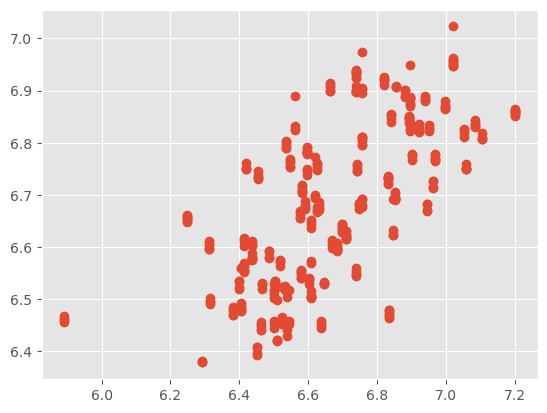

In [14]:
plt.plot('pred1', 'pred2', 'o', data = submission)

In [17]:
submission['sleep_hours'] = (submission['pred1'] + submission['pred2'] + submission['pred3'] + submission['pred4']) / 4
submission.head()

,date,sleep_hours,pred1,pred2,pred3,pred4
0,2022-01-01,6.893559,6.895420,6.948269,6.864333,6.866215
1,2022-01-02,6.960228,7.021891,6.952025,6.932096,6.934900
2,2022-01-03,6.538604,6.607022,6.503058,6.523519,6.520815
3,2022-01-04,6.549186,6.437583,6.578379,6.591282,6.589500
4,2022-01-05,6.554916,6.247111,6.655324,6.659045,6.658185


(array([ 7., 18., 47., 76., 40., 57., 50., 42., 66., 16.]),
 array([6.33157088, 6.39622265, 6.46087442, 6.52552619, 6.59017796,
        6.65482972, 6.71948149, 6.78413326, 6.84878503, 6.9134368 ,
        6.97808856]),
 <BarContainer object of 10 artists>)

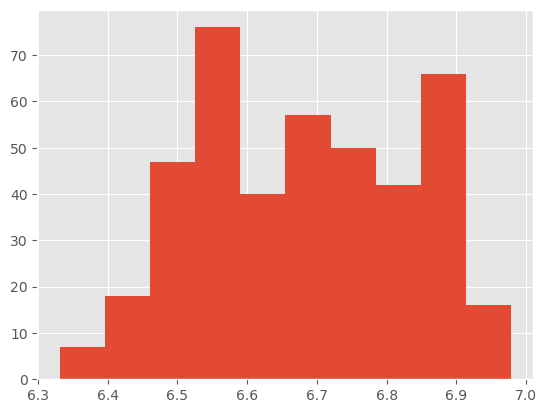

In [18]:
plt.hist('sleep_hours', data = submission)

In [19]:
submission.drop(columns = ['pred1', 'pred2', 'pred3', 'pred4'], axis = 1, inplace = True)
submission.to_csv('linear_average_ensemble.csv', index = False)

In [23]:
submission['pred1'] = test_new['sleep_hours']
submission['pred2'] = lasso_pred['sleep_hours']
submission['pred3'] = hist_pred['sleep_hours']
# submission['pred4'] = elastic_pred['sleep_hours']
submission.head()

,date,sleep_hours,pred1,pred2,pred3
0,2022-01-01,6.893559,6.895420,6.864333,7.028662
1,2022-01-02,6.960228,7.021891,6.932096,6.762038
2,2022-01-03,6.538604,6.607022,6.523519,6.578467
3,2022-01-04,6.549186,6.437583,6.591282,6.578271
4,2022-01-05,6.554916,6.247111,6.659045,6.572314


In [24]:
submission['sleep_hours'] = (submission['pred1'] + submission['pred2'] + submission['pred3']) / 3
submission.head()

,date,sleep_hours,pred1,pred2,pred3
0,2022-01-01,6.929472,6.895420,6.864333,7.028662
1,2022-01-02,6.905342,7.021891,6.932096,6.762038
2,2022-01-03,6.569669,6.607022,6.523519,6.578467
3,2022-01-04,6.535712,6.437583,6.591282,6.578271
4,2022-01-05,6.492824,6.247111,6.659045,6.572314


In [25]:
submission.describe()

,sleep_hours,pred1,pred2,pred3
count,419.000000,419.000000,419.000000,419.000000
mean,6.678766,6.673193,6.683049,6.680055
std,0.154095,0.229440,0.138848,0.138527
min,6.290699,5.891742,6.418670,6.443678
25%,6.538109,6.513948,6.569528,6.554488
50%,6.663425,6.636385,6.687723,6.672243
75%,6.835867,6.846788,6.793914,6.800861
max,6.985296,7.201818,6.932382,7.028662


In [26]:
submission.drop(columns = ['pred1', 'pred2', 'pred3'], axis = 1, inplace = True)
submission.to_csv('linear_hist_average_ensemble.csv', index = False)

In [27]:
submission['pred1'] = test_new['sleep_hours']
submission['pred2'] = lasso_pred['sleep_hours']
# submission['pred3'] = hist_pred['sleep_hours']
# submission['pred4'] = elastic_pred['sleep_hours']
submission.head()

,date,sleep_hours,pred1,pred2
0,2022-01-01,6.929472,6.895420,6.864333
1,2022-01-02,6.905342,7.021891,6.932096
2,2022-01-03,6.569669,6.607022,6.523519
3,2022-01-04,6.535712,6.437583,6.591282
4,2022-01-05,6.492824,6.247111,6.659045


In [28]:
submission['sleep_hours'] = (submission['pred1'] + submission['pred2']) / 2
submission.head()

,date,sleep_hours,pred1,pred2
0,2022-01-01,6.879877,6.895420,6.864333
1,2022-01-02,6.976994,7.021891,6.932096
2,2022-01-03,6.565271,6.607022,6.523519
3,2022-01-04,6.514433,6.437583,6.591282
4,2022-01-05,6.453078,6.247111,6.659045


In [29]:
submission.drop(columns = ['pred1', 'pred2'], axis = 1, inplace = True)
submission.to_csv('linear_average_ensemble_1.csv', index = False)

# Removing Outliers

In [2]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm import tqdm

import holidays

from functools import partial
import scipy as sp

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

from scipy.stats import rankdata
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold, TimeSeriesSplit, GroupKFold
from sklearn.metrics import mean_squared_error, roc_auc_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/Pog-Series/Rob-Sleep-Prediction/train.csv'
file_key_2 = 'Tabular-Playground-Series/Pog-Series/Rob-Sleep-Prediction/test.csv'
file_key_3 = 'Tabular-Playground-Series/Pog-Series/Rob-Sleep-Prediction/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
train['date'] = pd.to_datetime(train['date'])

test = pd.read_csv(file_content_stream_2)
test['date'] = pd.to_datetime(test['date'])

submission = pd.read_csv(file_content_stream_3)

def get_holidays(df):
    years_list = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

    holiday_US = holidays.CountryHoliday('US', years = years_list)
    holiday_dict = holiday_US.copy()

    df['holiday_name'] = df['date'].map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')
    
#     return df
    return df.drop(columns = ['holiday_name'])


def feature_engineer(df):
    
    new_df = df.copy()
    new_df["month"] = df["date"].dt.month
    new_df["month_sin"] = np.sin(new_df['month'] * (2 * np.pi / 12))
#     new_df["month_cos"] = np.cos(new_df['month'] * (2 * np.pi / 12))
    
    new_df["day"] = df["date"].dt.day
    new_df["day_sin"] = np.sin(new_df['day'] * (2 * np.pi / 12))
#     new_df["day_cos"] = np.cos(new_df['day'] * (2 * np.pi / 12))
    
    new_df["day_of_week"] = df["date"].dt.dayofweek
#     new_df["day_of_week"] = new_df["day_of_week"].apply(lambda x: 0 if x <= 3 else(1 if x == 4 else (2 if x == 5 else (3))))
    
    new_df["day_of_year"] = df["date"].dt.dayofyear
    new_df["year"] = df["date"].dt.year
    
    return new_df

train = feature_engineer(train)
test = feature_engineer(test)

train = get_holidays(train)
test = get_holidays(test)

train.loc[((train['date'] >= '2017-09-27') & (train['date'] <= '2018-06-12')), 'sleep_hours'] = train.loc[((train['date'] >= '2017-09-27') & (train['date'] <= '2018-06-12')), 'sleep_hours'] / 1.94 

X = train.drop(columns = ['date', 'sleep_hours', 'year'], axis = 1)
Y = train['sleep_hours']

test = test.drop(columns = ['date', 'sleep_hours', 'year'], axis = 1)

train = train[train['date'] > '2015-07-20'].reset_index(drop = True)

## Removing outliers
train = train[~((train['sleep_hours'] < 4) | (train['sleep_hours'] > 8))].reset_index()

train_agg = pd.DataFrame(train.groupby(['month', 'day_of_week'])['sleep_hours'].mean()).reset_index()
train_agg.head(50)

,month,day_of_week,sleep_hours
0,1,0,6.546636
1,1,1,6.483076
2,1,2,6.247111
3,1,3,6.763976
4,1,4,6.707684
5,1,5,6.777026
6,1,6,6.884309
7,2,0,6.603490
8,2,1,6.412428
9,2,2,6.620556


In [26]:
train_agg[train_agg['day_of_week'] >= 4]

,month,day_of_week,sleep_hours
4,1,4,6.707684
5,1,5,6.777026
6,1,6,6.884309
11,2,4,6.778183
12,2,5,7.086453
13,2,6,6.971641
18,3,4,7.024018
19,3,5,6.711087
20,3,6,6.680408
25,4,4,6.548619


In [10]:
submission.head(10)

,date,sleep_hours
0,2022-01-01,1
1,2022-01-02,1
2,2022-01-03,1
3,2022-01-04,1
4,2022-01-05,1
5,2022-01-06,1
6,2022-01-07,1
7,2022-01-08,1
8,2022-01-19,1
9,2022-01-20,1


In [8]:
test.head(30)

,month,month_sin,day,day_sin,day_of_week,day_of_year,is_holiday
0,1,0.500000,1,5.000000e-01,5,1,1
1,1,0.500000,2,8.660254e-01,6,2,0
2,1,0.500000,3,1.000000e+00,0,3,0
3,1,0.500000,4,8.660254e-01,1,4,0
4,1,0.500000,5,5.000000e-01,2,5,0
5,1,0.500000,6,1.224647e-16,3,6,0
6,1,0.500000,7,-5.000000e-01,4,7,0
7,1,0.500000,8,-8.660254e-01,5,8,0
8,1,0.500000,19,-5.000000e-01,2,19,0
9,1,0.500000,20,-8.660254e-01,3,20,0


In [13]:
ridge_pred = pd.read_csv('ridge_baseline_optuna_submission_no_outliers.csv')

test_new = pd.merge(test[['month', 'day_of_week']], train_agg, on = ['month', 'day_of_week'], how = 'left')
test_new.columns = ['month', 'day_of_week', 'avg_hours']

test_new['ridge'] = ridge_pred['sleep_hours']
test_new.head(60)

,month,day_of_week,avg_hours,ridge
0,1,5,6.777026,6.948305
1,1,6,6.884309,6.952028
2,1,0,6.546636,6.503054
3,1,1,6.483076,6.578376
4,1,2,6.247111,6.655323
5,1,3,6.763976,6.733207
6,1,4,6.707684,6.811092
7,1,5,6.777026,6.888039
8,1,2,6.247111,6.658858
9,1,3,6.763976,6.735805


In [15]:
test_new['sleep_hours'] = (test_new['avg_hours'] + test_new['ridge']) / 2
test_new.head(50)

,month,day_of_week,avg_hours,ridge,sleep_hours
0,1,5,6.777026,6.948305,6.862665
1,1,6,6.884309,6.952028,6.918169
2,1,0,6.546636,6.503054,6.524845
3,1,1,6.483076,6.578376,6.530726
4,1,2,6.247111,6.655323,6.451217
5,1,3,6.763976,6.733207,6.748592
6,1,4,6.707684,6.811092,6.759388
7,1,5,6.777026,6.888039,6.832533
8,1,2,6.247111,6.658858,6.452985
9,1,3,6.763976,6.735805,6.749890


In [18]:
test_new['sleep_hours'] = np.where(((test_new['day_of_week'] == 5) & (test_new['avg_hours'] > 7)), test_new['avg_hours'], test_new['sleep_hours'])
test_new['sleep_hours'] = np.where(((test_new['day_of_week'] == 6) & (test_new['avg_hours'] > 7)), test_new['avg_hours'], test_new['sleep_hours'])
test_new.head(70)

,month,day_of_week,avg_hours,ridge,sleep_hours
0,1,5,6.777026,6.948305,6.862665
1,1,6,6.884309,6.952028,6.918169
2,1,0,6.546636,6.503054,6.524845
3,1,1,6.483076,6.578376,6.530726
4,1,2,6.247111,6.655323,6.451217
...,...,...,...,...,...
65,3,4,7.024018,6.770846,6.897432
66,3,5,6.711087,6.848731,6.779909
67,3,6,6.680408,6.925678,6.803043
68,3,0,6.714123,6.478580,6.596352


In [19]:
test_new.describe()

,month,day_of_week,avg_hours,ridge,sleep_hours
count,419.000000,419.000000,419.000000,419.000000,419.000000
mean,5.785203,3.035800,6.623545,6.683455,6.655681
std,3.597802,1.990686,0.184523,0.151490,0.157766
min,1.000000,0.000000,6.205346,6.378522,6.296091
25%,2.000000,1.000000,6.492577,6.553569,6.528881
50%,5.000000,3.000000,6.610223,6.681054,6.644171
75%,9.000000,5.000000,6.760867,6.811306,6.780157
max,12.000000,6.000000,7.086453,7.022936,7.086453


In [23]:
submission['sleep_hours'] = test_new['sleep_hours']
submission.head(30)

,date,sleep_hours
0,2022-01-01,6.862665
1,2022-01-02,6.918169
2,2022-01-03,6.524845
3,2022-01-04,6.530726
4,2022-01-05,6.451217
5,2022-01-06,6.748592
6,2022-01-07,6.759388
7,2022-01-08,6.832533
8,2022-01-19,6.452985
9,2022-01-20,6.749890


In [24]:
submission.to_csv('ridge_average_ensemble_no_outliers.csv', index = False)

In [27]:
train_agg = pd.DataFrame(train.groupby(['month', 'day'])['sleep_hours'].mean()).reset_index()
train_agg.head(50)

,month,day,sleep_hours
0,1,1,6.459851
1,1,2,6.887357
2,1,3,6.765650
3,1,4,6.486667
4,1,5,6.845089
5,1,6,6.443915
6,1,7,6.824212
7,1,8,6.738846
8,1,9,6.270647
9,1,10,6.494788
